# Generalized Linear Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['lines.markeredgecolor'] = 'w'
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['figure.figsize'] = [8, 6]

Linear Regression

![](images/normal-glm.png)

Is linear regression a good choice for this data?

Why or why not?

![](images/poisson-data.png)

What if $Y$ is the number of counts of something (e.g., # of spikes)?

Is linear regression appropriate?

![](images/poisson-data.png)

**Linear Model**

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n$

$y = \hat{y} + Normal(\hat{y}, \sigma)$

**Generalized Linear Model**

$\hat{y} = f(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)$

* $f$ can be a nonlinear function (e.g., $exp$)

$y = \hat{y} + probdist(\hat{y})$

* $probdist$ is a probability distribution that need not be normal

![](images/GLM-diagram.png)

**Poisson GLM**

$\hat{y} = exp(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)$

$y = \hat{y} + Poisson(\hat{y})$

* Only non-negative integer counts
* The variance will increase with the number of counts

![](images/poisson-glm.png)

**Bernoulli GLM = Logistic Regression**

$\hat{y} = sigmoid(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)}}$

$y = \hat{y} + Bernoulli(\hat{y})$

* Only 0 or 1
* This is a binary classifier

![](images/bernoulli-glm.png)

![](images/poisson-logistic-diagram.png)

# Example for Poisson GLM

### Modeling retinal ganglion spike train by fitting a temporal receptive field

Adapted from [Neuromatch Academy](https://neuronline.sfn.org/scientific-research/tutorial-1-generalized-linear-models)

In [7]:
# data from Jonathan Pillow's lab: https://github.com/pillowlab/GLMspiketraintutorial
stimulus = np.load('retinal_ganglion_stimulus.npy')
spikes = np.load('retinal_ganglion_spikes.npy')

stimulus.shape, spikes.shape

((20000,), (20000,))

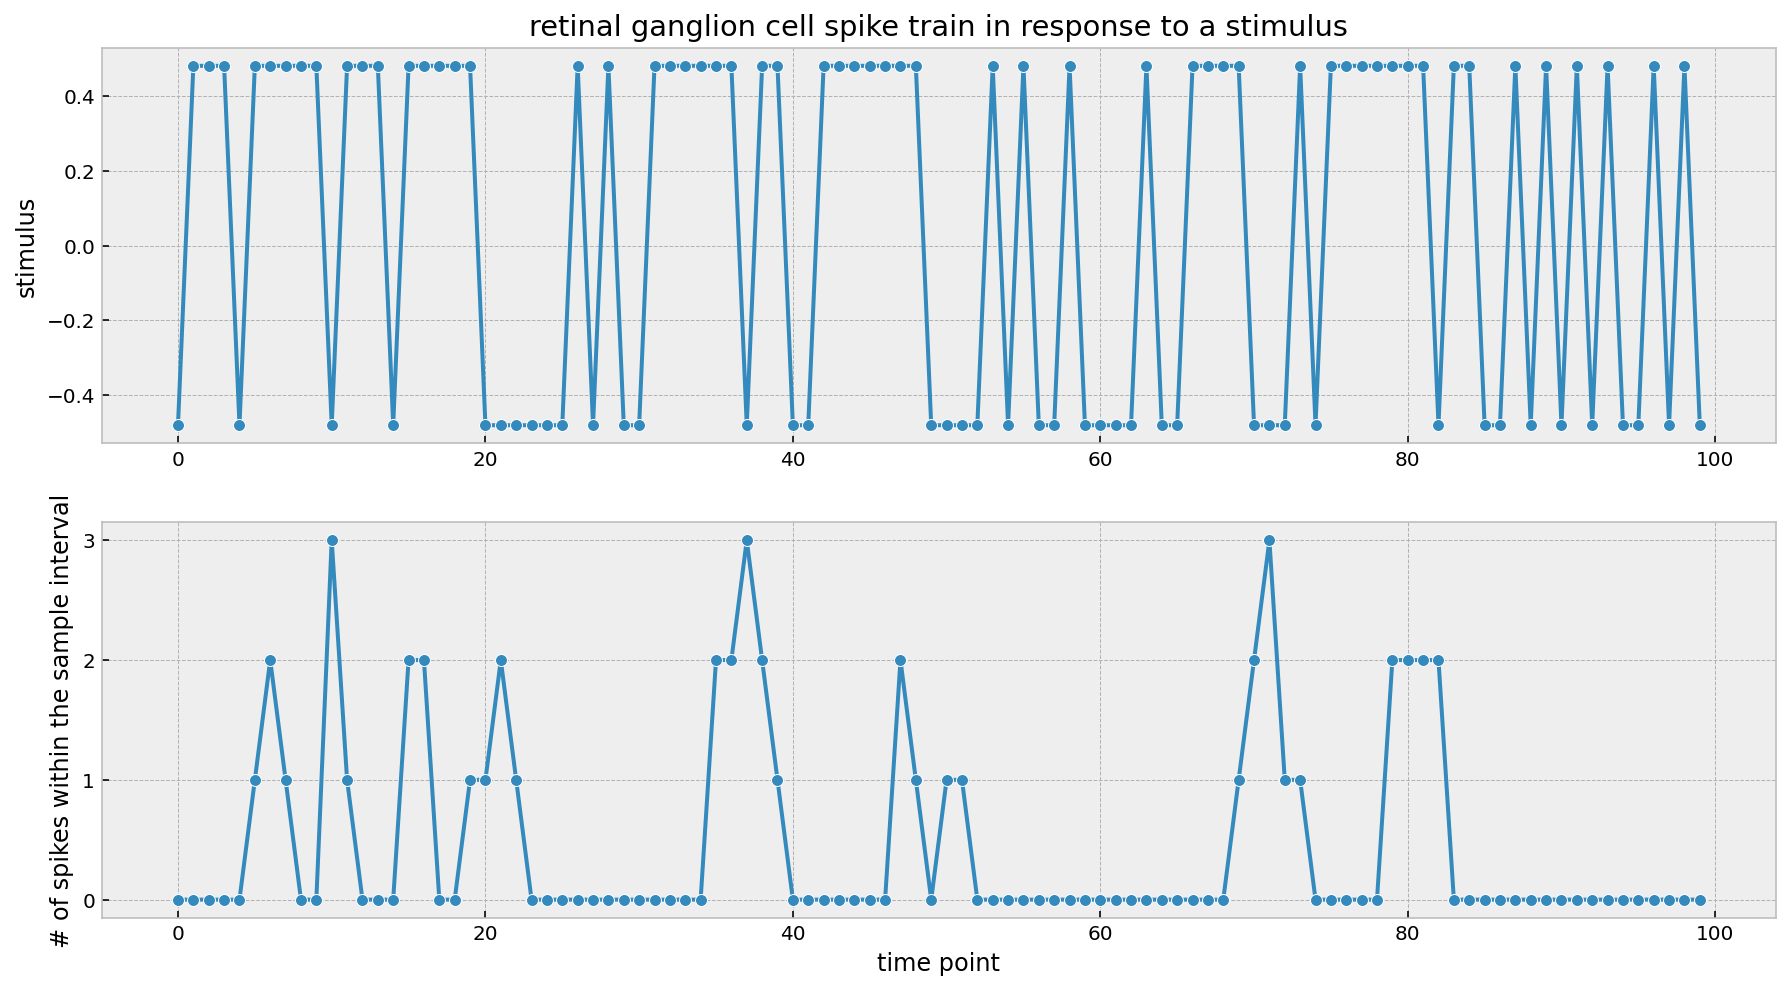

In [3]:
# retinal ganglion stimulus and spike data
plt.figure(figsize=[15,8])
plt.subplot(211)
plt.plot(stimulus[:100], 'o-')
plt.ylabel('stimulus')
plt.title('retinal ganglion cell spike train in response to a stimulus')
plt.subplot(212)
plt.plot(spikes[:100], 'o-')
plt.yticks(range(4))
plt.ylabel('# of spikes within the sample interval')
plt.xlabel('time point');

How might you construct a linear model that predicts the number of spikes in each sample interval based on the temporally preceding stimulus (e.g., the last 25 time points).

For example, at every time point $t$, you might predict the number of spikes within that sample interval based on a linear combination of the stimulus over the preceding 25 time points (including time point $t$).

$\text{#} spikes(t) = \beta_0 + \beta_1 stimulus(t-24) + \beta_2 stimulus(t-23) + ... + \beta_{25} stimulus(t)$

This is a simple linear model:

$\hat{y}_t = \beta_0 + \beta_1 x_{t-24} + \beta_2 x_{t-23} + ... + \beta_{25} x_{t}$

$\hat{y}_t = \beta_0 + \beta_1 x_{t-24} + \beta_2 x_{t-23} + ... + \beta_{25} x_{t}$

$\begin{bmatrix} \vdots \\ \hat{y}_t \\ \vdots \end{bmatrix} = \beta_0
+ \beta_1 \begin{bmatrix} \vdots \\ x_{t-24} \\ \vdots \end{bmatrix}
+ \beta_2 \begin{bmatrix} \vdots \\ x_{t-23} \\ \vdots \end{bmatrix}
+ \dots
+ \beta_{25} \begin{bmatrix} \vdots \\ x_t \\ \vdots \end{bmatrix}$

$X = 
\begin{bmatrix} 
\vdots & \vdots & & \vdots \\ 
x_{t-24} & x_{t-23} & \dots & x_t \\ 
\vdots & \vdots & & \vdots 
\end{bmatrix}$

Construct $X$: 

In [4]:
def stimulus_to_X(stimulus):
    T = len(stimulus)
    X = np.zeros((T, 25))
    for t in range(T):
        if t < 24:
            X[t,-t-1:] = stimulus[:t+1]  # last t columns of row t
        else:
            X[t,:] = stimulus[t-24:t+1]  # full row t
    return X

X = stimulus_to_X(stimulus)
y = spikes

In [6]:
pd.DataFrame(X, 
             index=[f"t={t}" for t in range(len(stimulus))], 
             columns=[fr"$\Delta$t={dt}" for dt in range(-24,1)])

,$\Delta$t=-24,$\Delta$t=-23,$\Delta$t=-22,$\Delta$t=-21,$\Delta$t=-20,$\Delta$t=-19,$\Delta$t=-18,$\Delta$t=-17,$\Delta$t=-16,$\Delta$t=-15,...,$\Delta$t=-9,$\Delta$t=-8,$\Delta$t=-7,$\Delta$t=-6,$\Delta$t=-5,$\Delta$t=-4,$\Delta$t=-3,$\Delta$t=-2,$\Delta$t=-1,$\Delta$t=0
t=0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.48
t=1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.48,0.48
t=2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.48,0.48,0.48
t=3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.48,0.48,0.48,0.48
t=4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,-0.48,0.48,0.48,0.48,-0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
t=19995,-0.48,0.48,0.48,0.48,0.48,-0.48,-0.48,0.48,-0.48,-0.48,...,0.48,0.48,0.48,-0.48,0.48,0.48,-0.48,0.48,0.48,-0.48
t=19996,0.48,0.48,0.48,0.48,-0.48,-0.48,0.48,-0.48,-0.48,-0.48,...,0.48,0.48,-0.48,0.48,0.48,-0.48,0.48,0.48,-0.48,0.48
t=19997,0.48,0.48,0.48,-0.48,-0.48,0.48,-0.48,-0.48,-0.48,-0.48,...,0.48,-0.48,0.48,0.48,-0.48,0.48,0.48,-0.48,0.48,-0.48
t=19998,0.48,0.48,-0.48,-0.48,0.48,-0.48,-0.48,-0.48,-0.48,-0.48,...,-0.48,0.48,0.48,-0.48,0.48,0.48,-0.48,0.48,-0.48,-0.48


# Question

Should you standardize the columns of $X$?

Why or why not?

# Exercise

Fit a linear model that predicts the spike counts $y$ based on the preceding time windows $X$.

In [ ]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()

# fit the model to the data X, y
...

# predict the spike counts based on the stimulus
lin_spikes = ...

In [222]:
# predict the number of spikes following a random train of stimulus values
lin_model.predict(np.random.choice([-0.48, 0.48], size=[1,25]))

array([-0.20860881])

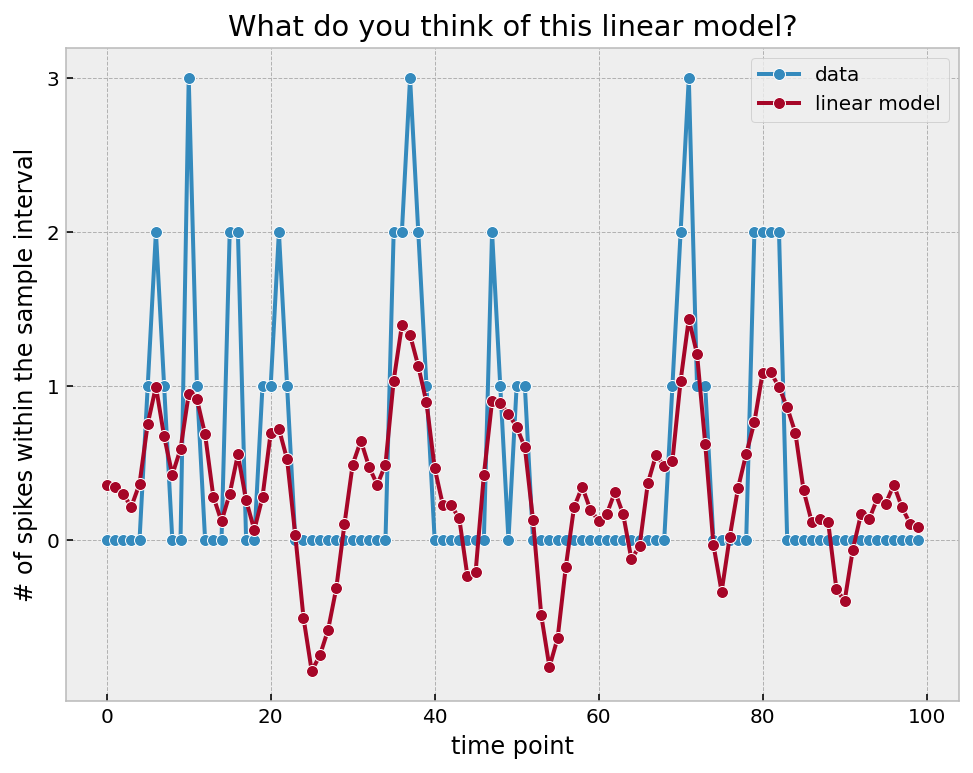

In [97]:
# linear model spike count prediction
plt.plot(spikes[:100], 'o-', label='data')
plt.plot(lin_spikes[:100], 'o-', label='linear model')
plt.yticks(range(4))
plt.ylabel('# of spikes within the sample interval')
plt.xlabel('time point')
plt.title('What do you think of this linear model?')
plt.legend();

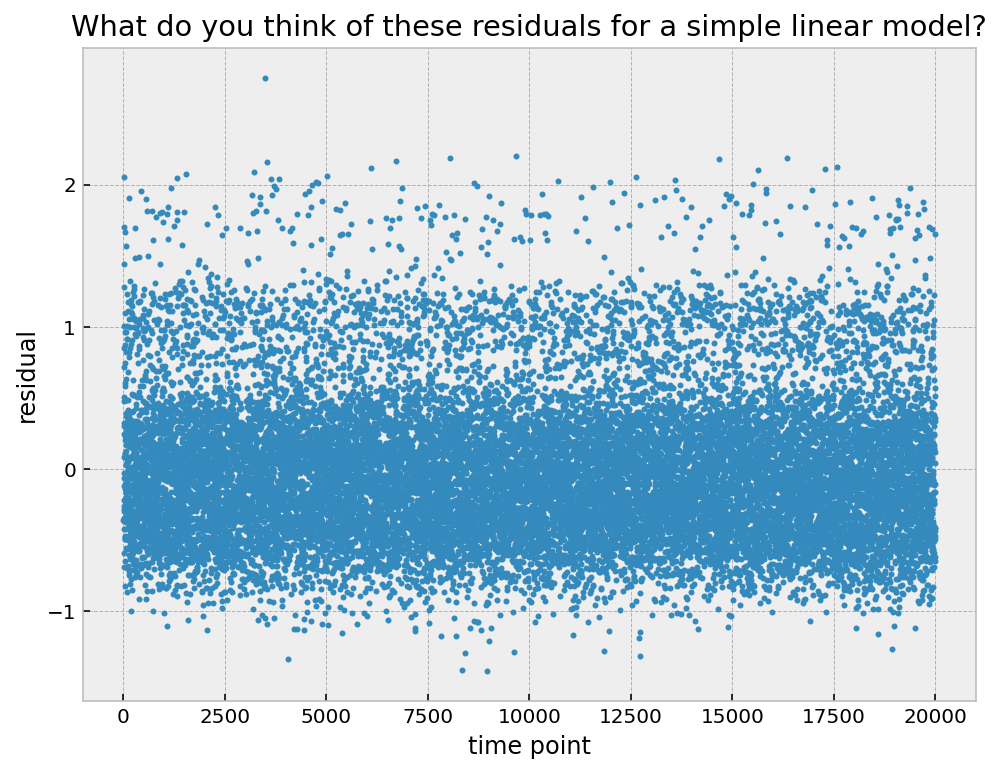

In [98]:
lin_residuals = spikes - lin_spikes

plt.plot(lin_residuals, '.', mew=0)
plt.xlabel('time point')
plt.ylabel('residual')
plt.title('What do you think of these residuals for a simple linear model?');

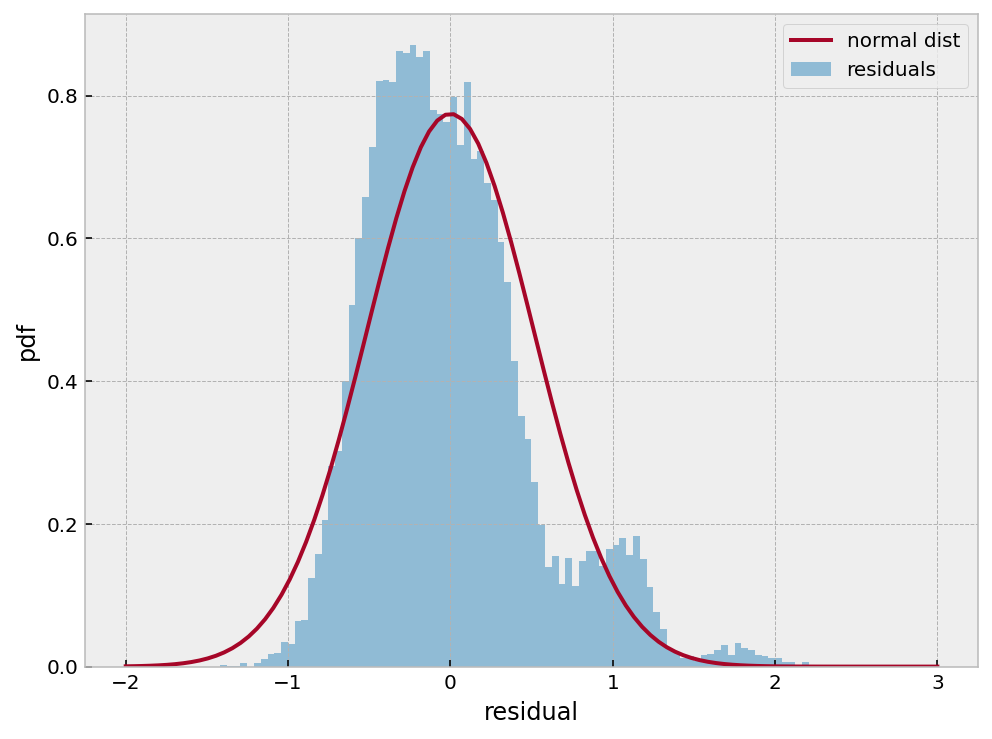

In [105]:
import scipy.stats as st

plt.hist(lin_residuals, 100, density=True, alpha=0.5, label='residuals')
plt.xlabel('residual')
plt.ylabel('pdf')

x = np.linspace(-2, 3, 100)
pdf = st.norm(lin_residuals.mean(), lin_residuals.std()).pdf(x)
plt.plot(x, pdf, label='normal dist')

plt.legend();

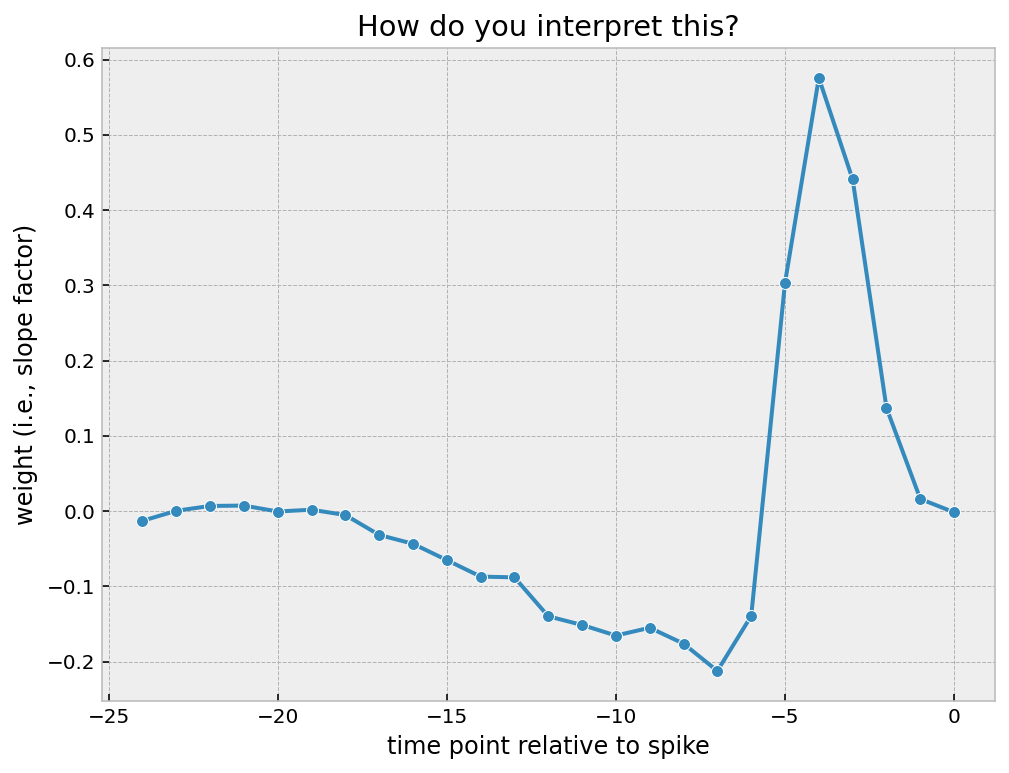

In [72]:
plt.plot(range(-24, 1), lin_model.coef_, 'o-', label='linear model')
plt.xlabel('time point relative to spike')
plt.ylabel('weight (i.e., slope factor)')
plt.title('How do you interpret this?');

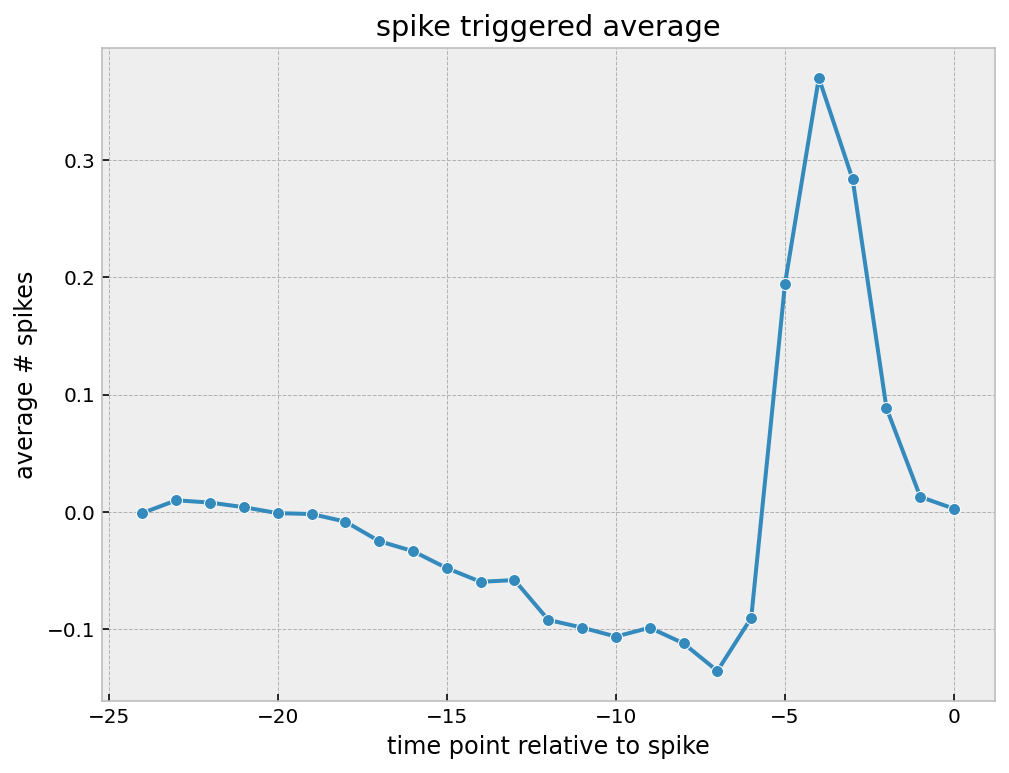

In [73]:
STA = X.T @ y / y.sum()

plt.plot(range(-24, 1), STA, 'o-', label='linear model')
plt.xlabel('time point relative to spike')
plt.ylabel('average # spikes')
plt.title('spike triggered average');

### Use a Poisson GLM to describe the spike rate as a function of the preceding stimulus.

$\hat{y}_t = exp(\beta_0 + \beta_1 x_{t-24} + \beta_2 x_{t-23} + ... + \beta_{25} x_{t})$

$y = \hat{y} + Poisson(\hat{y})$

The input $X$ is exactly the same as for the linear model.

$X = 
\begin{bmatrix} 
\vdots & \vdots & & \vdots \\ 
x_{t-24} & x_{t-23} & \dots & x_t \\ 
\vdots & \vdots & & \vdots 
\end{bmatrix}$

In [226]:
from sklearn.linear_model import PoissonRegressor

poisson_model = PoissonRegressor(alpha=0)  # alpha is for a concept we'll discuss later

# fit the model to the data X, y
poisson_model.fit(X, y)

# predict the spike counts based on the stimulus
poisson_spikes = poisson_model.predict(X)

In [225]:
# predict the number of spikes following a random train of stimulus values
poisson_model.predict(np.random.choice([-0.48, 0.48], size=[1,25]))

array([0.23426866])

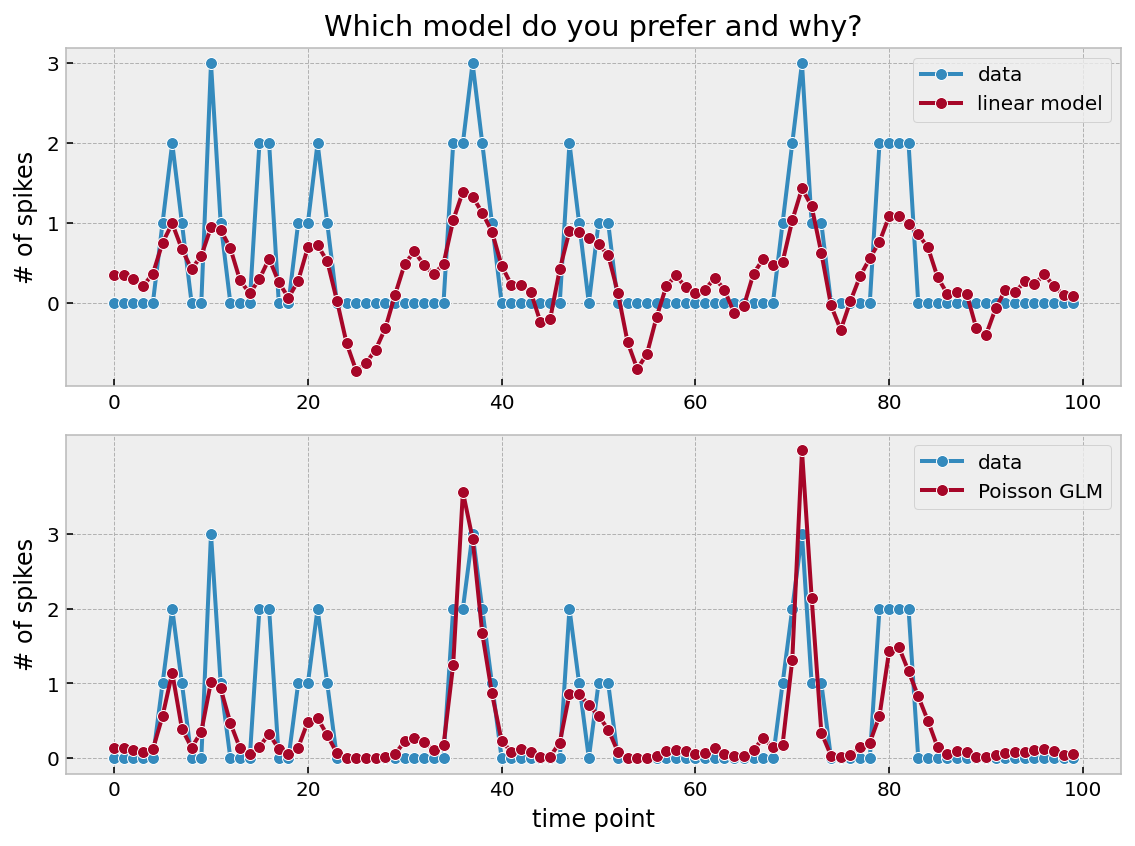

In [101]:
# linear model vs. poisson GLM spike count prediction
plt.subplot(211)
plt.plot(spikes[:100], 'o-', label='data')
plt.plot(lin_spikes[:100], 'o-', label='linear model')
plt.yticks(range(4))
plt.ylabel('# of spikes')
plt.title('Which model do you prefer and why?')
plt.legend()
plt.subplot(212)
plt.plot(spikes[:100], 'o-', label='data')
plt.plot(poisson_spikes[:100], 'o-', label='Poisson GLM')
plt.yticks(range(4))
plt.xlabel('time point')
plt.ylabel('# of spikes')
plt.legend()
plt.tight_layout();

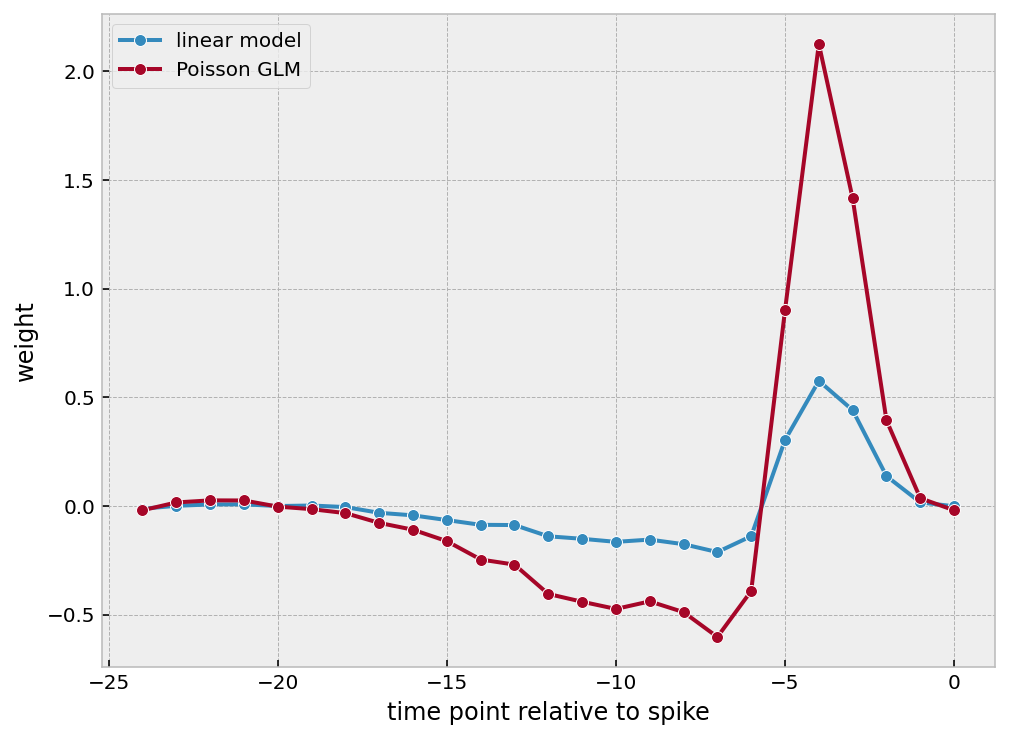

In [264]:
plt.plot(range(-24, 1), lin_model.coef_, 'o-', label='linear model')
plt.plot(range(-24, 1), poisson_model.coef_, 'o-', label='Poisson GLM')
plt.xlabel('time point relative to spike')
plt.ylabel('weight')
plt.legend();

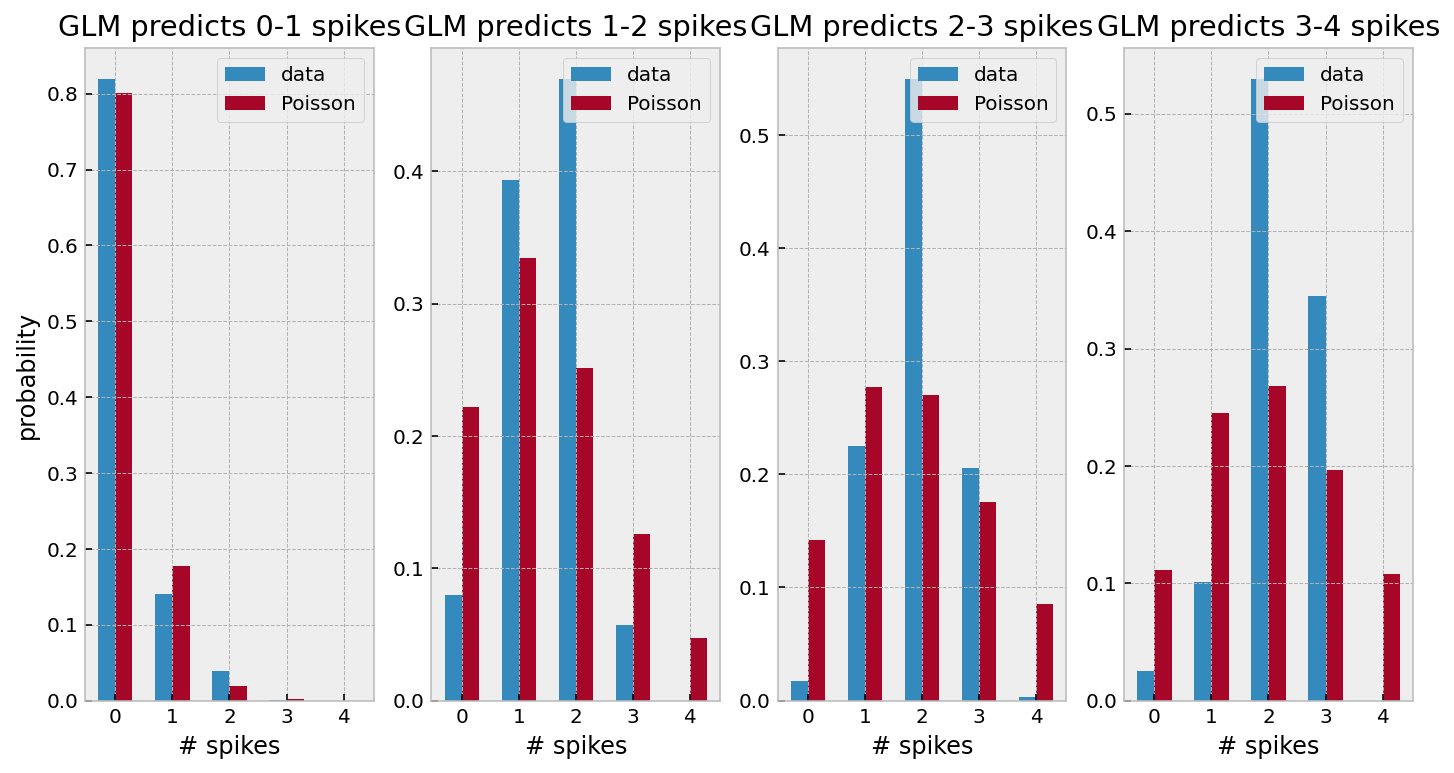

In [179]:
plt.figure(figsize=[15,6])
for i in range(4):
    ispikes = spikes[(poisson_spikes >= i) & (poisson_spikes < i+1)]
    
    bins = np.arange(5)
    bin_edges = np.arange(6) - 0.5
    counts = np.histogram(ispikes, bins=bin_edges, density=True)[0]
    
    pmf = st.poisson(ispikes.mean()).pmf(bins)
    
    plt.subplot(1, 5, i+1)
    plt.bar(bins-0.15, counts, width=0.3, label='data')
    plt.bar(bins+0.15, pmf, width=0.3, label='Poisson')
    plt.xticks(bins)
    plt.xlabel('# spikes')
    if i == 0:
        plt.ylabel('probability')
    plt.title(f"GLM predicts {i}-{i+1} spikes")
    plt.legend()

What does the above plot tell you about this Poisson GLM?

What response does the Poisson GLM spiking model predict for a step stimulus?

In [212]:
step_stimulus = np.ones(500) * -0.48
step_stimulus[100:400] = 0.48

Xstep = stimulus_to_X(step_stimulus)

step_spikes = poisson_model.predict(Xstep)

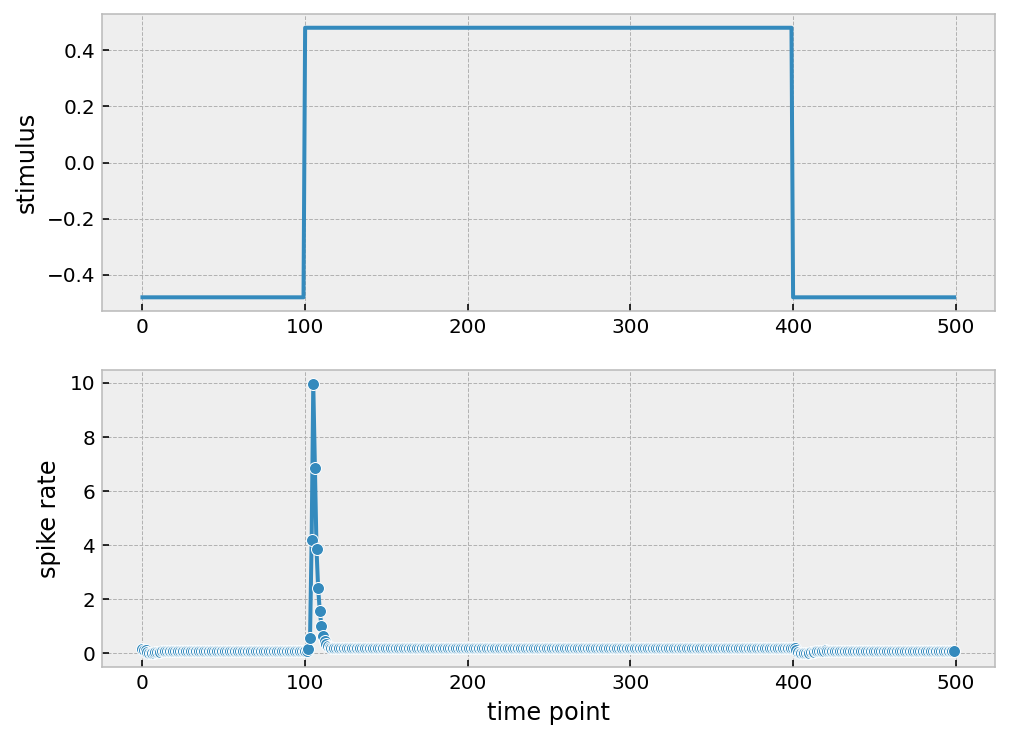

In [213]:
# step stimulus-response
plt.subplot(211)
plt.plot(step_stimulus)
plt.ylabel('stimulus')
plt.subplot(212)
plt.plot(step_spikes, 'o-')
plt.xlabel('time point')
plt.ylabel('spike rate');

# Exercise

Use the Poisson GLM spike rate model to predict a retinal ganglion cell response to an input that switches back and forth between OFF and ON every 25 time points (500 time points total).

In [210]:
onoff_stimulus = np.array(([-0.48]*25 + [0.48]*25)*10)

Xonoff = ...

onoff_spikes = ...

In [ ]:
# on/off stimulus-response
plt.subplot(211)
plt.plot(onoff_stimulus)
plt.ylabel('stimulus')
plt.subplot(212)
plt.plot(onoff_spikes, 'o-')
plt.xlabel('time point')
plt.ylabel('spike rate');

# Example

Consider the following task from [Steinmetz et al. (2019)](https://www.nature.com/articles/s41586-019-1787-x): For a repeated series of trials, a mouse is trained to rotate a wheel to indicate whether it perceives a Gabor pattern to the left or right. Spike rates from many cortical neurons are recorded on each trial. The goal is to build a model that can predict the mouse's choice based on the spiking of its cortical neurons.

![](images/gabor.png)

Adapted from [Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/W1D4_GeneralizedLinearModels/student/W1D4_Tutorial2.html)

# Question

Is a linear model appropriate in this case?

Why or why not?

Load the data:

* `choices`: mouse chooses whether a Gabor stimulus is to the left or right on each of 276 trials 
* `spikes`: normalized spike rates for each of 691 neurons across the cortex recorded with Neuropixel probes on each trial

In [8]:
spikes = np.load('mouse_cortical_spiking.npy')
choices = np.load('mouse_left_right_choices.npy')

spikes.shape, choices.shape

((276, 691), (276,))

In [249]:
choices[:9]

array([1., 1., 0., 0., 0., 0., 1., 0., 0.])

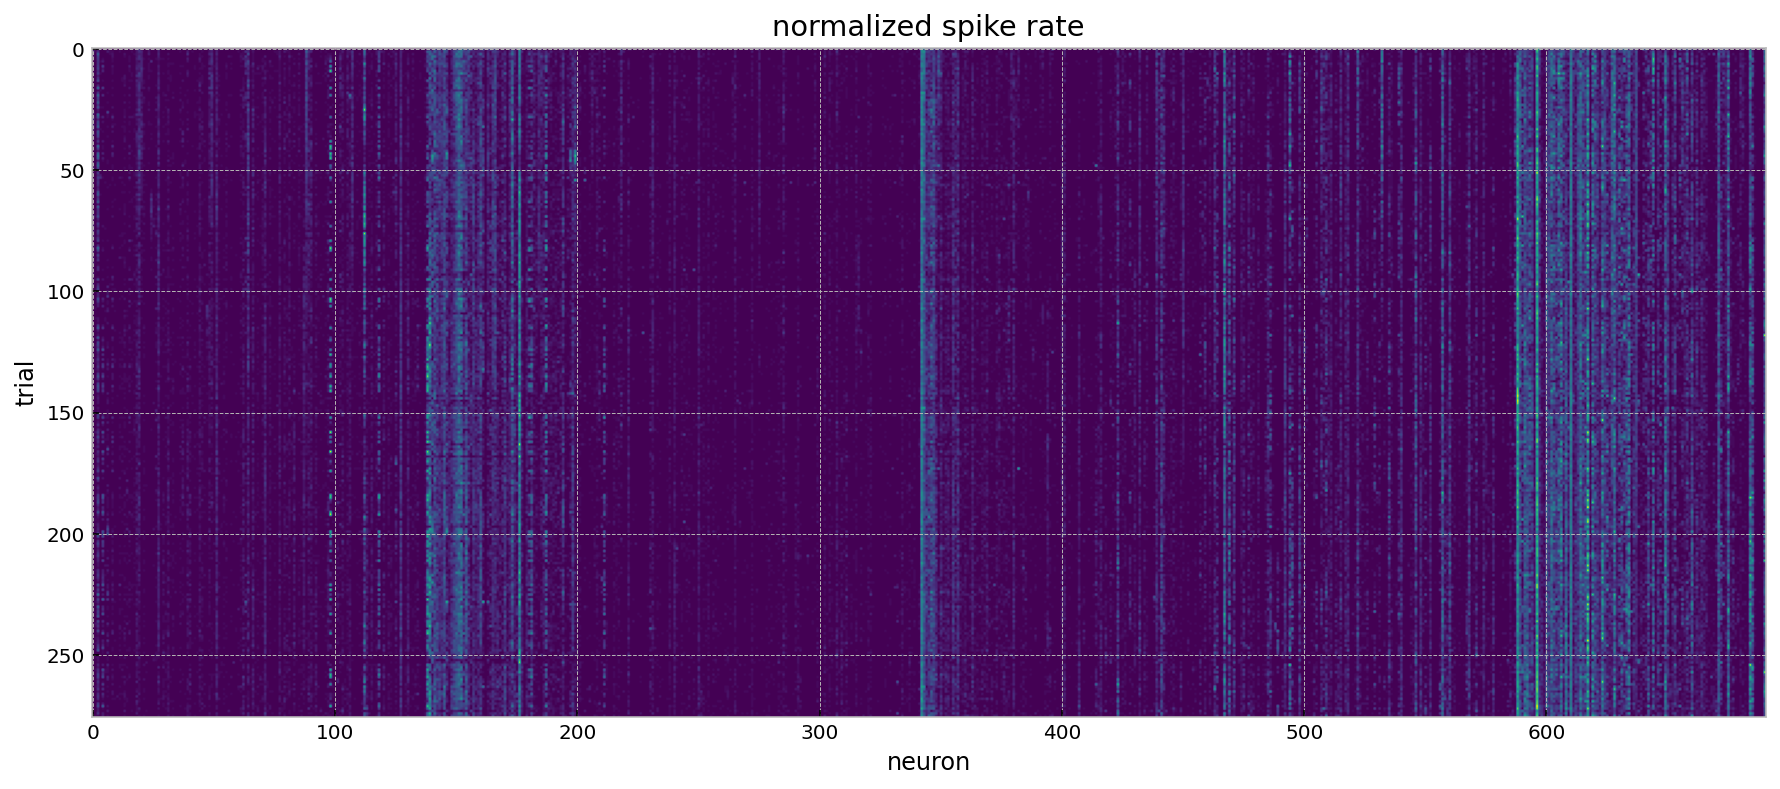

In [248]:
plt.figure(figsize=[15,8])
plt.imshow(spikes)
plt.xlabel('neuron')
plt.ylabel('trial')
plt.title('normalized spike rate');

### Use a logistic regression (Bernoulli GLM) to predict the mouse's choice based on its cortical activity.

In [251]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(penalty='none')  # penalty relates to a concept we'll discuss later

# fit the model to the data
X = ...
y = ...
logreg_model.fit(X, y)

# predict the mouse's choice based on its cortical activity
logreg_choices = ...

How well did the model do?

In [252]:
# accuracy = % correct
accuracy = (choices == logreg_choices).mean()

accuracy

1.0

Which neurons are associated with choosing left vs. right?

Which neurons have little influence on the choice?

In [261]:
logreg_model.coef_.shape

(1, 691)

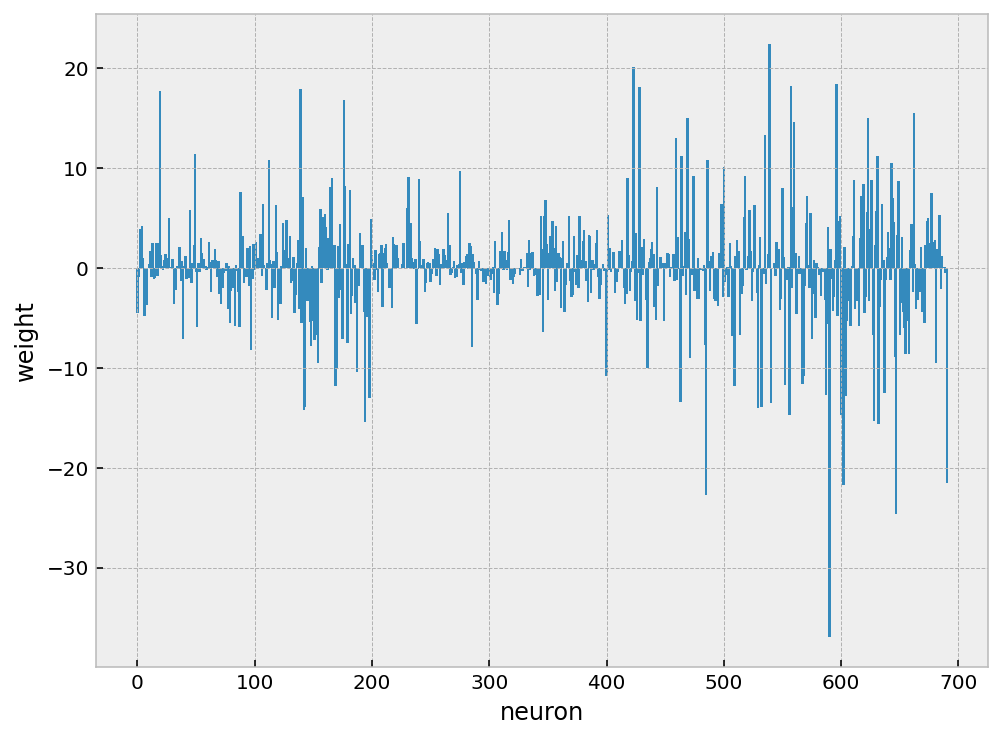

In [272]:
plt.bar(np.arange(691), logreg_model.coef_.reshape([-1]), width=2)
plt.xlabel('neuron')
plt.ylabel('weight');

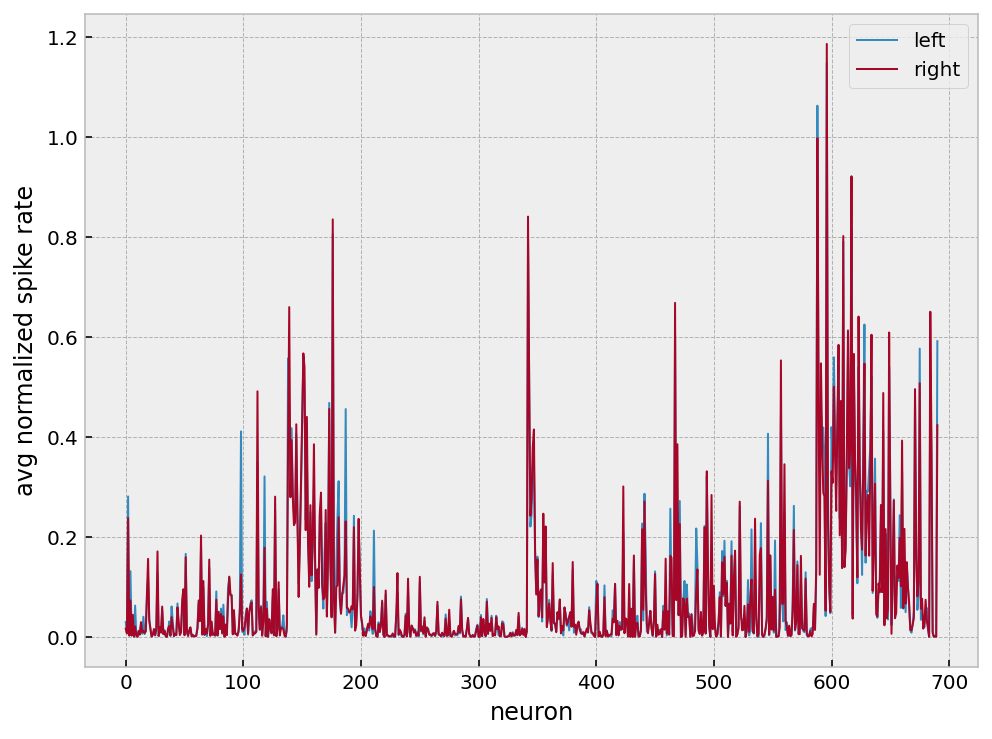

In [269]:
avg_spikes_left = spikes[choices == 0,:].mean(axis=0)
avg_spikes_right = spikes[choices == 1,:].mean(axis=0)

plt.plot(avg_spikes_left, lw=1, label='left')
plt.plot(avg_spikes_right, lw=1, label='right')
plt.xlabel('neuron')
plt.ylabel('avg normalized spike rate')
plt.legend();

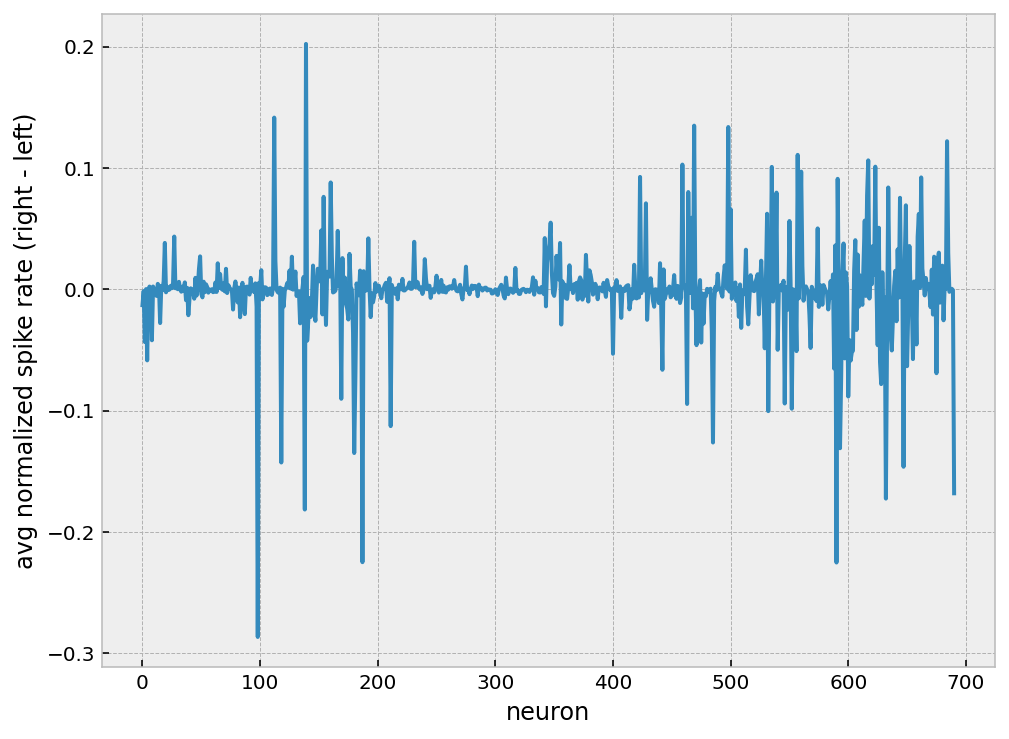

In [268]:
plt.plot(avg_spikes_right - avg_spikes_left)
plt.xlabel('neuron')
plt.ylabel('avg normalized spike rate (right - left)');

# Exercise

Predict the mouses choice on two new trials given the normalized spike rates for the neurons on each trial.

In [ ]:
# spikes for two new trials
spikes1 = 0.8 * avg_spikes_right + 0.2 * avg_spikes_left
spikes2 = 0.3 * avg_spikes_right + 0.7 * avg_spikes_left

# new feature matrix has two rows (one for each trial)
Xnew = np.vstack([spikes1, spikes2])

# predict the new choices
new_choices = ...

new_choices

But an acuracy of 100% seems too good to be true.

If it is, what might be going on?

We'll address this later ;)